#Product Analytics - New User Booking #

## **1.0 Problem Statement** ##

New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking and better forecast demand, thus increasing revenue.

In this project, a list of users along with their demographics, web session records, and some summary statistics is given. The purpose of the project is to develop a predictive model that predicts the Airbnb new users' first booking destination amongst the 12 possible outcomes. 



## **2.0 Packages** ##

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
import datetime
import os
import seaborn as sns
from datetime import date
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import pickle
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import *

## **3.0 Dataset** ##

Airbnb New User Bookings:

https://www.kaggle.com/competitions/airbnb-recruiting-new-user-bookings/data

**File descriptions**

The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

- train_users.csv - the training set of users
- test_users.csv - the test set of users
 * id: user id
 * date_account_created: the date of account creation
 * timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or date_first_booking because a user can search before signing up
 * date_first_booking: date of first booking
 * gender
 * age
 * signup_method
 * signup_flow: the page a user came to signup up from
 * language: international language preference
 * affiliate_channel: what kind of paid marketing
 * affiliate_provider: where the marketing is e.g. google, craigslist, other
 * first_affiliate_tracked: whats the first marketing the user interacted with before the signing up
 * signup_app
 * first_device_type
 * first_browser
 * country_destination: this is the target variable you are to predict
- sessions.csv - web sessions log for users
 * user_id: to be joined with the column 'id' in users table
 * action
 * action_type
 * action_detail
 * device_type
 * secs_elapsed
- countries.csv - summary statistics of destination countries in this dataset and their locations
- age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination


### 3.1 Load the Dataset ###

In [3]:
# Load the training and test datasets
df_train = pd.read_csv('train_users_2.csv')
df_test = pd.read_csv('test_users.csv')
sessions = pd.read_csv('sessions.csv')
usergrp = pd.read_csv('age_gender_bkts.csv')
countries = pd.read_csv('countries.csv')

### 3.2 Dataset Exploration ###

* #### 3.2.1 For 'age_gender_bkts.csv': ####

In [ ]:
# Show 'age_gender_bkts.csv' dataset
print(usergrp)

    age_bucket country_destination  gender  population_in_thousands    year
0         100+                  AU    male                      1.0  2015.0
1        95-99                  AU    male                      9.0  2015.0
2        90-94                  AU    male                     47.0  2015.0
3        85-89                  AU    male                    118.0  2015.0
4        80-84                  AU    male                    199.0  2015.0
..         ...                 ...     ...                      ...     ...
415      95-99                  US    male                    115.0  2015.0
416      90-94                  US    male                    541.0  2015.0
417      15-19                  US  female                  10570.0  2015.0
418      85-89                  US    male                   1441.0  2015.0
419      80-84                  US    male                   2442.0  2015.0

[420 rows x 5 columns]


In [ ]:
# Check Data Dimensions
print('Number of rows and columns are: {}'.format(usergrp.shape))
print('.....................................................')

# Check Data Type
usergrp.info()
print('.....................................................')

# Count the number of each dtype
print(usergrp.dtypes.value_counts())
print('.....................................................')

# Check the missing value
print(usergrp.isnull().sum())
print(f'Thus, there is no missing value in the dataset.')

Number of rows and columns are: (420, 5)
.....................................................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420 entries, 0 to 419
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age_bucket               420 non-null    object 
 1   country_destination      420 non-null    object 
 2   gender                   420 non-null    object 
 3   population_in_thousands  420 non-null    float64
 4   year                     420 non-null    float64
dtypes: float64(2), object(3)
memory usage: 16.5+ KB
.....................................................
object     3
float64    2
dtype: int64
.....................................................
age_bucket                 0
country_destination        0
gender                     0
population_in_thousands    0
year                       0
dtype: int64
Thus, there is no missing value in the dataset.


In [ ]:
# Count the value of each column
for col in usergrp.columns:
    print ("---- %s ----" % col)
    print (usergrp[col].value_counts())

---- age_bucket ----
100+     20
45-49    20
5-9      20
10-14    20
15-19    20
20-24    20
25-29    20
30-34    20
35-39    20
40-44    20
50-54    20
95-99    20
55-59    20
60-64    20
65-69    20
70-74    20
75-79    20
80-84    20
85-89    20
90-94    20
0-4      20
Name: age_bucket, dtype: int64
---- country_destination ----
AU    42
CA    42
DE    42
ES    42
FR    42
GB    42
IT    42
NL    42
PT    42
US    42
Name: country_destination, dtype: int64
---- gender ----
male      210
female    210
Name: gender, dtype: int64
---- population_in_thousands ----
3.0       6
1.0       3
9.0       3
13.0      3
115.0     2
         ..
1040.0    1
1198.0    1
1087.0    1
1909.0    1
2442.0    1
Name: population_in_thousands, Length: 381, dtype: int64
---- year ----
2015.0    420
Name: year, dtype: int64


**Comment**: As shown in the above, 'year' column' had only one value in 'age_gender_bkts.csv' dataset, so we could drop this column as it provided no useful information.

In [ ]:
# Drop the 'year' column
usergrp = usergrp.drop(['year'], axis=1)
print(usergrp.sample())

  age_bucket country_destination gender  population_in_thousands
3      85-89                  AU   male                    118.0


* #### 3.2.2 For 'countries.csv': ####

In [ ]:
# Show 'countries.csv' dataset
print(countries.head())

  country_destination  lat_destination  lng_destination  distance_km  \
0                  AU       -26.853388       133.275160   15297.7440   
1                  CA        62.393303       -96.818146    2828.1333   
2                  DE        51.165707        10.452764    7879.5680   
3                  ES        39.896027        -2.487694    7730.7240   
4                  FR        46.232193         2.209667    7682.9450   

   destination_km2 destination_language   language_levenshtein_distance  
0        7741220.0                   eng                           0.00  
1        9984670.0                   eng                           0.00  
2         357022.0                   deu                          72.61  
3         505370.0                   spa                          92.25  
4         643801.0                   fra                          92.06  


In [ ]:
# Check Data Dimensions
print('Number of rows and columns are: {}'.format(countries.shape))
print('.....................................................')

# Check Data Type
countries.info()
print('.....................................................')

# Count the number of each dtype
print(countries.dtypes.value_counts())
print('.....................................................')

# Check the missing value
print(countries.isnull().sum())
print(f'Thus, there is no missing value in the dataset.')
print('.....................................................')

# Descriptive Statistics
countries.describe()

Number of rows and columns are: (10, 7)
.....................................................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   country_destination            10 non-null     object 
 1   lat_destination                10 non-null     float64
 2   lng_destination                10 non-null     float64
 3   distance_km                    10 non-null     float64
 4   destination_km2                10 non-null     float64
 5   destination_language           10 non-null     object 
 6   language_levenshtein_distance  10 non-null     float64
dtypes: float64(5), object(2)
memory usage: 688.0+ bytes
.....................................................
float64    5
object     2
dtype: int64
.....................................................
country_destination              0
lat_destination           

,lat_destination,lng_destination,distance_km,destination_km2,language_levenshtein_distance
count,10.000000,10.000000,10.000000,1.000000e+01,10.00000
mean,39.799398,-4.262446,7181.897800,2.973734e+06,50.49900
std,24.739112,63.700585,3941.141734,4.329619e+06,44.54169
min,-26.853388,-96.818146,0.000000,4.154300e+04,0.00000
25%,39.639090,-6.737559,7001.557600,2.580425e+05,0.00000
50%,44.053092,-0.139014,7603.632650,4.311960e+05,67.91500
75%,51.891219,9.163386,7842.357000,5.966865e+06,91.39500
max,62.393303,133.275160,15297.744000,9.984670e+06,95.45000


As shown in the above, 'countries.csv' dataset was clean and extremely small, thus no cleaning techniques would be needed.

* #### 3.2.3 For 'sessions.csv': ####

In [ ]:
# Show 'sessions.csv' dataset
print(sessions.head())

      user_id          action action_type        action_detail  \
0  d1mm9tcy42          lookup         NaN                  NaN   
1  d1mm9tcy42  search_results       click  view_search_results   
2  d1mm9tcy42          lookup         NaN                  NaN   
3  d1mm9tcy42  search_results       click  view_search_results   
4  d1mm9tcy42          lookup         NaN                  NaN   

       device_type  secs_elapsed  
0  Windows Desktop         319.0  
1  Windows Desktop       67753.0  
2  Windows Desktop         301.0  
3  Windows Desktop       22141.0  
4  Windows Desktop         435.0  


In [ ]:
# Rename 'user_id' column for the further table merge step
sessions = sessions.rename(columns = {'user_id':'id'})

In [ ]:
# Check Data Dimensions
print('Number of rows and columns are: {}'.format(sessions.shape))
print('.....................................................')

# Check Data Type
sessions.info()
print('.....................................................')

# Count the number of each dtype
print(sessions.dtypes.value_counts())
print('.....................................................')

# Check the missing value
print(sessions.isnull().sum())
print('.....................................................')

# Descriptive Statistics
#countries.describe()

Number of rows and columns are: (10567737, 6)
.....................................................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
 #   Column         Dtype  
---  ------         -----  
 0   id             object 
 1   action         object 
 2   action_type    object 
 3   action_detail  object 
 4   device_type    object 
 5   secs_elapsed   float64
dtypes: float64(1), object(5)
memory usage: 483.8+ MB
.....................................................
object     5
float64    1
dtype: int64
.....................................................
id                 34496
action             79626
action_type      1126204
action_detail    1126204
device_type            0
secs_elapsed      136031
dtype: int64
.....................................................


**Comment**: 
As indicated by the above result, there were significant amount of missing values existed in the 'action', 'action_type', 'action_detail' and 'secs_elapsed' columns. Thus, these unknown fields were converted into NaN to give it more semantic meaning, while 'secs_elapsed' column would be handled in the future step.


In [ ]:
# Fill-in the missing values
sessions.action = sessions.action.fillna('NAN')
sessions.action_type = sessions.action_type.fillna('NAN')
sessions.action_detail = sessions.action_detail.fillna('NAN')

# Check the missing value
print(sessions.isnull().sum())

id                34496
action                0
action_type           0
action_detail         0
device_type           0
secs_elapsed     136031
dtype: int64


* #### 3.2.4 For 'train_user_2.csv' and 'test_user.csv': #### 

In [ ]:
# Show datasets
print(df_train.sample())
print('.........................................................................')
print(df_test.sample())

               id date_account_created  timestamp_first_active  \
40358  dvg5bh3pkt           2012-09-10          20120910212004   

      date_first_booking  gender   age signup_method  signup_flow language  \
40358                NaN  FEMALE  36.0      facebook            0       en   

      affiliate_channel affiliate_provider first_affiliate_tracked signup_app  \
40358            direct             direct               untracked        Web   

      first_device_type first_browser country_destination  
40358       Mac Desktop        Safari                 NDF  
.........................................................................
               id date_account_created  timestamp_first_active  \
43314  bcell3b0g1           2014-08-31          20140831235045   

       date_first_booking     gender  age signup_method  signup_flow language  \
43314                 NaN  -unknown-  NaN         basic           25       en   

      affiliate_channel affiliate_provider first_affiliat

In [ ]:
# Check Data Dimensions
print('Number of rows and columns for training dataset are: {}'.format(df_train.shape))
print('Number of rows and columns for test dataset are: {}'.format(df_test.shape))


Number of rows and columns for training dataset are: (213451, 16)
Number of rows and columns for test dataset are: (62096, 15)


**Comment**: The above dimension info indicated that training dataset had one more variable named 'country_destination' than test dataset, which was the target column.

In [ ]:
# Check Data Type
print(df_train.info())
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       213451 non-null  object 
 1   date_account_created     213451 non-null  object 
 2   timestamp_first_active   213451 non-null  int64  
 3   date_first_booking       88908 non-null   object 
 4   gender                   213451 non-null  object 
 5   age                      125461 non-null  float64
 6   signup_method            213451 non-null  object 
 7   signup_flow              213451 non-null  int64  
 8   language                 213451 non-null  object 
 9   affiliate_channel        213451 non-null  object 
 10  affiliate_provider       213451 non-null  object 
 11  first_affiliate_tracked  207386 non-null  object 
 12  signup_app               213451 non-null  object 
 13  first_device_type        213451 non-null  object 
 14  firs

In [ ]:
# Count the number of each dtype
print('For training dataset:\n', df_train.dtypes.value_counts())
print('For test dataset:\n',df_test.dtypes.value_counts())

For training dataset:
 object     13
int64       2
float64     1
dtype: int64
For test dataset:
 object     11
int64       2
float64     2
dtype: int64


In [ ]:
# Check the missing value
print('For training dataset:\n', df_train.isnull().sum())
print('For test dataset:\n', df_test.isnull().sum())

For training dataset:
 id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64
For test dataset:
 id                             0
date_account_created           0
timestamp_first_active         0
date_first_booking         62096
gender                         0
age                        28876
signup_method                  0
signup_flow                    0
language                       0
affiliate_channel              0
affiliate_provider             0
first_affiliate_tracked       20
signu

As significant missing values existed in 'date_first_booking' of both datasets, this feature should be removed.

  * *3.2.4.1 'date_account_created'*

In [ ]:
# Value_counts for 'date_account_created'
print('For df_train.date_account_created: \n', df_train.date_account_created.value_counts())
print('For df_test.date_account_created: \n', df_test.date_account_created.value_counts())

For df_train.date_account_created: 
 2014-05-13    674
2014-06-24    670
2014-06-25    636
2014-05-20    632
2014-05-14    622
             ... 
2010-03-09      1
2010-01-28      1
2010-01-31      1
2010-04-11      1
2010-06-18      1
Name: date_account_created, Length: 1634, dtype: int64
For df_test.date_account_created: 
 2014-07-23    1105
2014-07-22    1052
2014-07-17     978
2014-07-24     923
2014-07-18     892
              ... 
2014-07-06     475
2014-07-12     472
2014-07-04     445
2014-07-05     421
2014-07-13     401
Name: date_account_created, Length: 92, dtype: int64


In [ ]:
# Descriptive Statistics for 'date_account_created'
print('For df_train.date_account_created: \n', df_train.date_account_created.describe())
print('For df_test.date_account_created: \n', df_test.date_account_created.describe())

For df_train.date_account_created: 
 count         213451
unique          1634
top       2014-05-13
freq             674
Name: date_account_created, dtype: object
For df_test.date_account_created: 
 count          62096
unique            92
top       2014-07-23
freq            1105
Name: date_account_created, dtype: object


  * *3.2.4.2 'timestamp_first_active'* 

In [ ]:
# Check for duplicate value for 'timestamp_first_active'
print('For df_train.timestamp_first_active: \n', df_train.timestamp_first_active.value_counts().unique())
print('For df_test.timestamp_first_active: \n', df_test.timestamp_first_active.value_counts().unique())

For df_train.timestamp_first_active: 
 [1]
For df_test.timestamp_first_active: 
 [1]


**Comment**: There waw no duplicate value in 'timestamp_first_active' column of two datasets.

In [ ]:
# Descriptive Statistics for 'timestamp_first_active'

# Break down the timestamp to datetime
tfa_train_dt = df_train.timestamp_first_active.astype(str).apply(lambda x:  
                                                                    datetime.datetime(int(x[:4]),
                                                                                      int(x[4:6]), 
                                                                                      int(x[6:8]), 
                                                                                      int(x[8:10]), 
                                                                                      int(x[10:12]),
                                                                                      int(x[12:])))
tfa_test_dt = df_test.timestamp_first_active.astype(str).apply(lambda x:  
                                                                    datetime.datetime(int(x[:4]),
                                                                                      int(x[4:6]), 
                                                                                      int(x[6:8]), 
                                                                                      int(x[8:10]), 
                                                                                      int(x[10:12]),
                                                                                      int(x[12:])))
# Descirptive Statistics
print('For df_train.timestamp_first_active: \n', tfa_train_dt.describe())
print('For df_test.timestamp_first_active: \n', tfa_test_dt.describe())

For df_train.timestamp_first_active: 
 count                  213451
unique                 213451
top       2009-03-19 04:32:55
freq                        1
first     2009-03-19 04:32:55
last      2014-06-30 23:58:24
Name: timestamp_first_active, dtype: object
For df_test.timestamp_first_active: 
 count                   62096
unique                  62096
top       2014-07-01 00:00:06
freq                        1
first     2014-07-01 00:00:06
last      2014-09-30 23:59:01
Name: timestamp_first_active, dtype: object


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.


  * *3.2.4.3 'age'* 

In [ ]:
# Value Counts for 'age' column
print('For df_train.age: \n', df_train.age.value_counts())
print('For df_test.age: \n', df_test.age.value_counts())

For df_train.age: 
 30.0      6124
31.0      6016
29.0      5963
28.0      5939
32.0      5855
          ... 
1925.0       1
1935.0       1
1933.0       1
112.0        1
1926.0       1
Name: age, Length: 127, dtype: int64
For df_test.age: 
 28.0      1748
27.0      1724
26.0      1701
25.0      1690
29.0      1684
          ... 
1945.0       1
2000.0       1
1938.0       1
1939.0       1
108.0        1
Name: age, Length: 124, dtype: int64


**Comment**: The majority of users in the training dataset was at the age of 30 while the one in the testing dataset was around 28. Significant unusual values could be observed in both datasets, requiring the additional effort.

  * *3.2.4.4 'country_destination'* 

In [ ]:
# Value Counts for 'country_destination' column
print('For df_train.country_destination: \n', df_train.country_destination.value_counts())

For df_train.country_destination: 
 NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
Name: country_destination, dtype: int64


### 3.3 Exploratory Data Analysis ###

As the above statistics provided the limited info at this state, let's visualize the data to obtain more insights. 

* #### 3.3.1 User Growth Trend ('date_account_created') ####

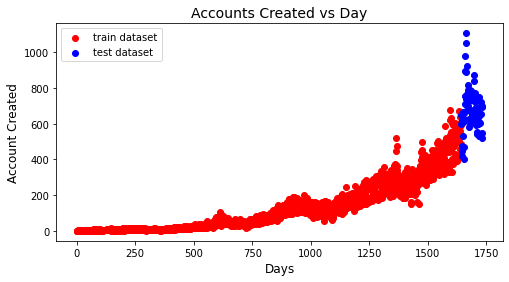

In [ ]:
# value counts of data account created columns
dac_train = df_train.date_account_created.value_counts()
dac_test = df_test.date_account_created.value_counts()

# Convert to datetime type
dac_train_date = pd.to_datetime(df_train.date_account_created.value_counts().index)
dac_test_date = pd.to_datetime(df_test.date_account_created.value_counts().index)

# Substract the first account creation date from the user creation date
dac_train_day = dac_train_date - dac_train_date.min()
dac_test_day = dac_test_date - dac_train_date.min()

# Scatter plot for user growth trend
plt.figure(figsize=(8, 4))
plt.rc('font', size=10)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=12)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10) 
plt.scatter(dac_train_day.days, dac_train.values, color = 'r', label = 'train dataset')
plt.scatter(dac_test_day.days, dac_test.values, color = 'b', label = 'test dataset')
plt.title("Accounts Created vs Day")
plt.xlabel("Days")
plt.ylabel("Account Created")
plt.legend(loc = 'upper left')

**Comment**: The above figure showed that a dramatic increasing trend in the new user account creation as time passed, especially for the test dataset.

* #### 3.3.2 Univariate Analysis ####

In [ ]:
# Define the function to obtain the plot for the categorical data
def feature_barplot(feature, df_train, df_test, figsize=(10,5), rot = 90, saveimg = False): 
    feat_train = df_train[feature].value_counts()
    feat_test = df_test[feature].value_counts()
    fig_feature, (axis1,axis2) = plt.subplots(1,2,sharex=True, sharey = True, figsize = figsize)
    sns.barplot(feat_train.index.values, feat_train.values, ax = axis1)
    sns.barplot(feat_test.index.values, feat_test.values, ax = axis2)
    axis1.set_xticklabels(axis1.xaxis.get_majorticklabels(), rotation = rot)
    axis2.set_xticklabels(axis1.xaxis.get_majorticklabels(), rotation = rot)
    axis1.set_title(feature + ' of training dataset')
    axis2.set_title(feature + ' of test dataset')
    axis1.set_ylabel('Counts')
    plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


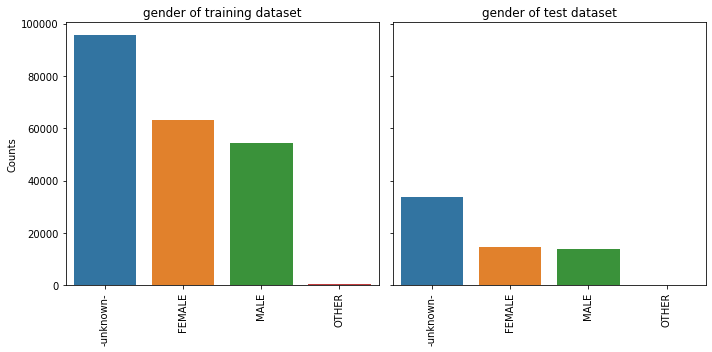

In [ ]:
# 'gender'
feature_barplot('gender', df_train, df_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


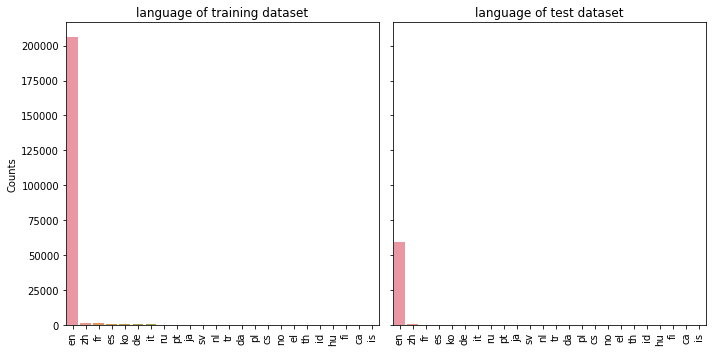

In [ ]:
# 'language'
feature_barplot('language', df_train, df_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


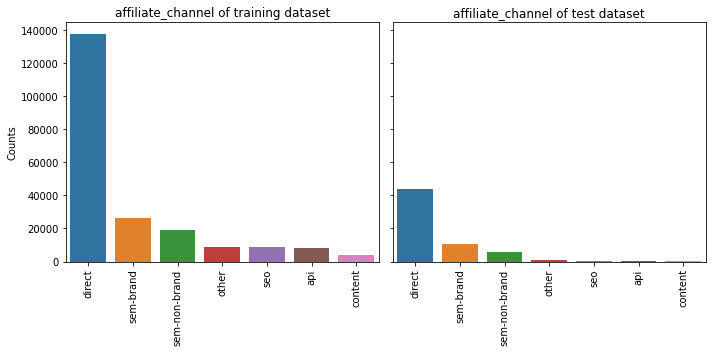

In [ ]:
# 'affiliate_channel'
feature_barplot('affiliate_channel', df_train, df_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


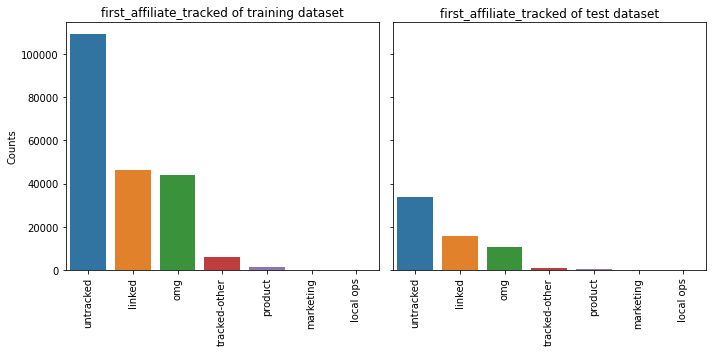

In [ ]:
# 'first_affiliate_tracked'
feature_barplot('first_affiliate_tracked', df_train, df_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


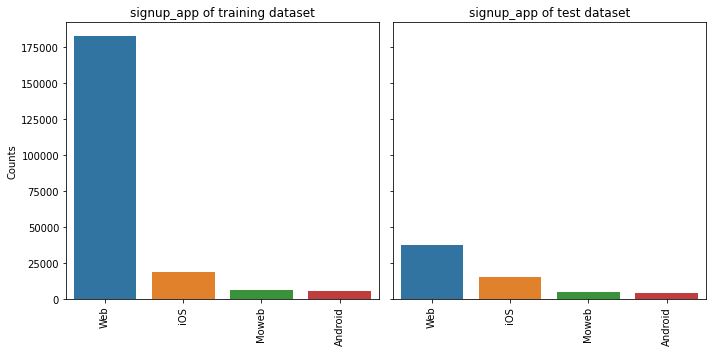

In [ ]:
# 'signup_app'
feature_barplot('signup_app', df_train, df_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


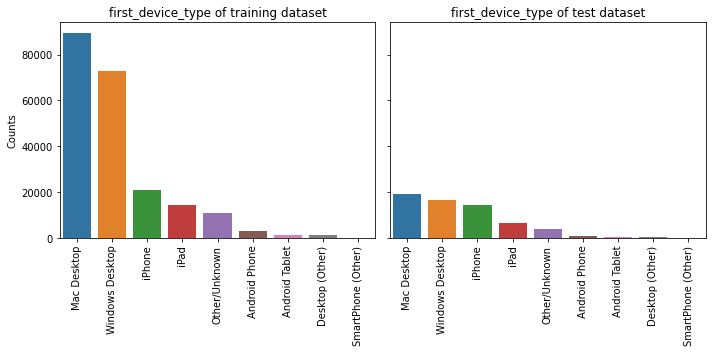

In [ ]:
# 'first_device_type'
feature_barplot('first_device_type', df_train, df_test)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


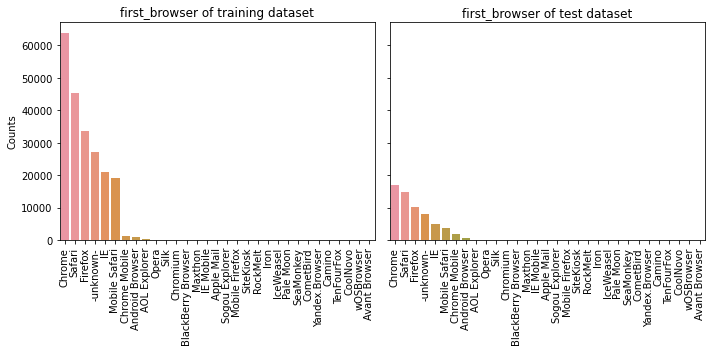

In [ ]:
# 'first_browser'
feature_barplot('first_browser', df_train, df_test)

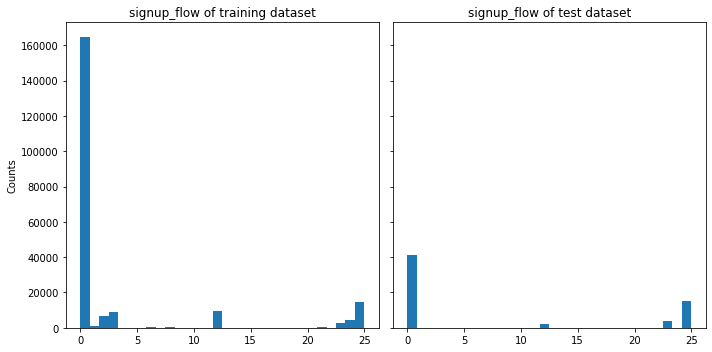

In [ ]:
# Histogram for 'signup_flow'
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True, figsize = (10,5))
axs[0].hist(df_train['signup_flow'], bins=30)
axs[1].hist(df_test['signup_flow'], bins=30)
axs[0].set_title('signup_flow of training dataset')
axs[1].set_title('signup_flow of test dataset')
axs[0].set_ylabel('Counts')
plt.tight_layout()

* #### 3.3.2 Gender Distribution ('age') ####

* #### 3.3.2 User Age Distribution ('age') ####

### 3.4 Feature Engineering ###

* #### 3.4.1 'sessions.csv' ####

In [ ]:
# Value Counts of User Actions
sessions.action.value_counts()

show              2768278
index              843699
search_results     725226
personalize        706824
search             536057
                   ...   
deauthorize             1
events                  1
reactivate              1
desks                   1
nyan                    1
Name: action, Length: 360, dtype: int64

**Comment**: The above results indicated that several actions were only occured once in the dataset. To simplify the dataset, let's replace the action values with frequency less than 100 with 'other'.

In [ ]:
# Replace 'Action' values with low frequency with 'other'
act_freq = 100  # threshold of frequency
act = dict(zip(*np.unique(sessions.action, return_counts=True)))
sessions.action = sessions.action.apply(lambda x: 'OTHER' if act[x] < act_freq else x)

In [ ]:
# Action
f_act = sessions.action.value_counts().argsort()
f_act_detail = sessions.action_detail.value_counts().argsort()
f_act_type = sessions.action_type.value_counts().argsort()
f_dev_type = sessions.device_type.value_counts().argsort()

# Groupby 
dgr_sess = sessions.groupby(['id'])

# Loop on dgr_sess to create all the features
samples = []
ln = len(dgr_sess) # Calculate the length of df_sessions after groupby

for g in dgr_sess: 
    gr = g[1]   # dataframe that comtains all the data for a groupby value 'zzywmcn0jv'
    l = []  # empty list
    l.append(g[0]) # fill the list with value
    l.append(len(gr)) # number of total actions
    sev = gr.secs_elapsed.fillna(0).values # fill the secs_elapsed with 0
    
    # action features 
    c_act = [0] * len(f_act)
    for i,v in enumerate(gr.action.values): #i is the place of 0-1，v represents the value of action feature for users
        c_act[f_act[v]] += 1
    _, c_act_uqc = np.unique(gr.action.values, return_counts=True)
    # Calculate the length, average and standard deviation
    c_act += [len(c_act_uqc), np.mean(c_act_uqc), np.std(c_act_uqc)]
    l = l + c_act
    
    #action_detail features
    #(how many times each value occurs, numb of unique values, mean and std)
    c_act_detail = [0] * len(f_act_detail)
    for i,v in enumerate(gr.action_detail.values):
        c_act_detail[f_act_detail[v]] += 1
    _, c_act_det_uqc = np.unique(gr.action_detail.values, return_counts=True)
    c_act_detail += [len(c_act_det_uqc), np.mean(c_act_det_uqc), np.std(c_act_det_uqc)]
    l = l + c_act_detail
    
    #action_type features
    #(how many times each value occurs, numb of unique values, mean and std
    #+ log of the sum of secs_elapsed for each value)
    l_act_type = [0] * len(f_act_type)
    c_act_type = [0] * len(f_act_type)
    for i,v in enumerate(gr.action_type.values):
        l_act_type[f_act_type[v]] += sev[i] #sev = gr.secs_elapsed.fillna(0).values
        c_act_type[f_act_type[v]] += 1  
    l_act_type = np.log(1 + np.array(l_act_type)).tolist() #, calculate the time span of each action
    _, c_act_type_uqc = np.unique(gr.action_type.values, return_counts=True)
    c_act_type += [len(c_act_type_uqc), np.mean(c_act_type_uqc), np.std(c_act_type_uqc)]
    l = l + c_act_type + l_act_type    
    
    #device_type features
    #(how many times each value occurs, numb of unique values, mean and std)
    c_dev_type  = [0] * len(f_dev_type)
    for i,v in enumerate(gr.device_type .values):
        c_dev_type[f_dev_type[v]] += 1 
    c_dev_type.append(len(np.unique(gr.device_type.values))) 
    _, c_dev_type_uqc = np.unique(gr.device_type.values, return_counts=True)
    c_dev_type += [len(c_dev_type_uqc), np.mean(c_dev_type_uqc), np.std(c_dev_type_uqc)]        
    l = l + c_dev_type    
    
    #secs_elapsed features    
    l_secs = [0] * 5 
    l_log = [0] * 15
    if len(sev) > 0:
        #Simple statistics about the secs_elapsed values.
        l_secs[0] = np.log(1 + np.sum(sev))
        l_secs[1] = np.log(1 + np.mean(sev)) 
        l_secs[2] = np.log(1 + np.std(sev))
        l_secs[3] = np.log(1 + np.median(sev))
        l_secs[4] = l_secs[0] / float(l[1]) #
        
        #Values are grouped in 15 intervals. Compute the number of values
        #in each interval.
        #sev = gr.secs_elapsed.fillna(0).values 
        log_sev = np.log(1 + sev).astype(int)
        #np.bincount():Count number of occurrences of each value in array of non-negative ints.  
        l_log = np.bincount(log_sev, minlength=15).tolist()                    
    l = l + l_secs + l_log
    
    #The list l has the feature values of one sample.
    samples.append(l)

# Preparing objects    
samples = np.array(samples) 
samp_ar = samples[:, 1:].astype(np.float16) # extract the features except 'id'
samp_id = samples[:, 0]   # extract 'id'

# Create a new dataframe     
col_names = []    #name of the columns
for i in range(len(samples[0])-1):  #-1 is because of 'id'
    col_names.append('c_' + str(i)) 
df_agg_sess = pd.DataFrame(samp_ar, columns=col_names)
df_agg_sess['id'] = samp_id
df_agg_sess.index = df_agg_sess.id # Set 'id' as index

In [ ]:
# Save file as csv
df_agg_sess.to_csv('df_agg_sessions.csv')

* #### 3.4.2 'train_users_2.csv' and 'test_users.csv' ####

In [ ]:
# Delete 'date_first_booking' and 'df_train.country_destination'
df_train.drop(['country_destination', 'date_first_booking'], axis = 1, inplace = True)
df_test.drop(['date_first_booking'], axis = 1, inplace = True)


In [ ]:
# Join training and test datasets
df_users = pd.concat([df_train, df_test], axis = 0, ignore_index = True)

  * *3.4.2.1 'timestamp_first_active'*

In [ ]:
# Convert data type to datetime type
tfa = df_users.timestamp_first_active.astype(str).apply(lambda x: datetime.datetime(int(x[:4]),
                                                                          int(x[4:6]), 
                                                                          int(x[6:8]),
                                                                          int(x[8:10]),
                                                                          int(x[10:12]),
                                                                          int(x[12:])))

# Extract 'year', 'month', 'day' feature from the datetime column
df_users['tfa_year'] = np.array([x.year for x in tfa])
df_users['tfa_month'] = np.array([x.month for x in tfa])
df_users['tfa_day'] = np.array([x.day for x in tfa])
df_users.sample()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,tfa_year,tfa_month,tfa_day
186235,sedditw4j9,2014-05-08,20140508082600,-unknown-,NaN,basic,23,ko,direct,direct,untracked,Android,Android Phone,-unknown-,2014,5,8


In [ ]:
# Extract 'weekday' feature from datetime column using one-hot encoding
df_users['tfa_wd'] = np.array([x.isoweekday() for x in tfa]) 
df_tfa_wd = pd.get_dummies(df_users.tfa_wd, prefix = 'tfa_wd')  # one hot encoding 
df_users = pd.concat((df_users, df_tfa_wd), axis = 1) # join
df_users.drop(['tfa_wd'], axis = 1, inplace = True) # drop the orignal 'weekday' column 
df_users.sample()

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,tfa_year,tfa_month,tfa_day,tfa_wd_1,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7
36248,hxdrq77jsl,2012-08-13,20120813051905,FEMALE,49.0,facebook,0,en,sem-non-brand,google,...,2012,8,13,1,0,0,0,0,0,0


In [ ]:
# Extract 'season' feature from datetime column

print(f'As the season feature only considers the month rather than the year feature, the year feature was set to a specific value to simplify the process.')

Y = 2000
seasons = [(0, (date(Y,  1,  1),  date(Y,  3, 20))),  #'winter'
           (1, (date(Y,  3, 21),  date(Y,  6, 20))),  #'spring'
           (2, (date(Y,  6, 21),  date(Y,  9, 22))),  #'summer'
           (3, (date(Y,  9, 23),  date(Y, 12, 20))),  #'autumn'
           (0, (date(Y, 12, 21),  date(Y, 12, 31)))]  #'winter'

def get_season(dt):
    dt = dt.date() # Obtain the date
    dt = dt.replace(year=Y) # Replace all year value with 2000
    return next(season for season, (start, end) in seasons if start <= dt <= end)

df_users['tfa_season'] = np.array([get_season(x) for x in tfa])
df_tfa_season = pd.get_dummies(df_users.tfa_season, prefix = 'tfa_season') # one hot encoding 
df_users = pd.concat((df_users, df_tfa_season), axis = 1)
df_users.drop(['tfa_season'], axis = 1, inplace = True)
df_users.sample()

As the season feature only considers the month rather than the year feature, the year feature was set to a specific value to simplify the process.


,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,tfa_wd_2,tfa_wd_3,tfa_wd_4,tfa_wd_5,tfa_wd_6,tfa_wd_7,tfa_season_0,tfa_season_1,tfa_season_2,tfa_season_3
202607,ai2kffd7bz,2014-06-10,20140610203015,FEMALE,31.0,basic,0,en,direct,direct,...,1,0,0,0,0,0,0,1,0,0


  * *3.4.2.2 'date_account_created'*

In [ ]:
# Convert data type to datetime type
dac = pd.to_datetime(df_users.date_account_created)

In [ ]:
# Extract 'year', 'month', 'day' feature for the dac column
df_users['dac_year'] = np.array([x.year for x in dac])
df_users['dac_month'] = np.array([x.month for x in dac])
df_users['dac_day'] = np.array([x.day for x in dac])

In [ ]:
# Extract 'weekday' feature for dac using one-hot encoding
df_users['dac_wd'] = np.array([x.isoweekday() for x in dac])
df_dac_wd = pd.get_dummies(df_users.dac_wd, prefix = 'dac_wd')
df_users = pd.concat((df_users, df_dac_wd), axis = 1)
df_users.drop(['dac_wd'], axis = 1, inplace = True)

In [ ]:
# Extract 'season' feature for dac
df_users['dac_season'] = np.array([get_season(x) for x in dac])
df_dac_season = pd.get_dummies(df_users.dac_season, prefix = 'dac_season')
df_users = pd.concat((df_users, df_dac_season), axis = 1)
df_users.drop(['dac_season'], axis = 1, inplace = True)

  * *3.4.2.3 'date_account_created' and 'timestamp_first_active'*

In [ ]:
# Create the dt_span variable to represent the time span between account creation and first activity
dt_span = dac.subtract(tfa).dt.days 

# User Activity Time Span value counts
dt_span.value_counts().head(10)

-1      275369
 0           7
 6           4
 1           4
 5           4
 2           3
 3           3
 28          3
 4           3
 103         2
dtype: int64

**Comment**: The above result showed that the majority time span from data account created to first active was '-1'. We could see '-1' representing that users had their first activity at the day they created the account.

Thus, we created the categorical feature based on time span of 1 days, 1 month, and 1 year.

In [ ]:
# Create categorical feature: span = -1; -1 < span < 30; 31 < span < 365; span > 365
def get_span(dt):
    # dt is an integer
    if dt == -1:
        return 'OneDay'
    elif (dt < 30) & (dt > -1):
        return 'OneMonth'
    elif (dt >= 30) & (dt <= 365):
        return 'OneYear'
    else:
        return 'other'
df_users['dt_span'] = np.array([get_span(x) for x in dt_span])
df_dt_span = pd.get_dummies(df_users.dt_span, prefix = 'dt_span')
df_users = pd.concat((df_users, df_dt_span), axis = 1)
df_users = df_users.drop(['dt_span'], axis = 1)

# Drop two columns
df_users = df_users.drop(['date_account_created','timestamp_first_active'], axis = 1)
df_users.sample()


,id,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,...,dac_wd_6,dac_wd_7,dac_season_0,dac_season_1,dac_season_2,dac_season_3,dt_span_OneDay,dt_span_OneMonth,dt_span_OneYear,dt_span_other
185250,y78h83bv7u,MALE,NaN,basic,0,en,direct,direct,linked,Web,...,0,0,0,1,0,0,1,0,0,0


 * *3.4.2.4 'age'*

In the 'Data Exploration' section, we observed that there were multiple abnormal values existed in the 'age' column. As some records were observed in the range of (1900, 2000), we could assume the users might write down their birthday instead of age and thus we made the adjustment for those values.


In [ ]:
# As the data was collected in 2014, we estimated users' age by doing (2014 - value)
av = df_users.age.values #obtain the age values
av = np.where(np.logical_and(av<2000, av>1900), 2014-av, av) # estimate the age
df_users['age'] = av

Then, there is still some inconsistency existed in the age value of multiple users, which might be caused by the age input field was not sanitized or there was some mistakes handlig the data in the 'age' column. Let's break down the age into discrete values, and return the unreasonable age value to 'unphysical'.


In [ ]:
# Age has many abnormal values that we need to deal with. 
age = df_users.age
age.fillna(-1, inplace = True) # fill-in the empty value with -1
div = 15
# Define function to slice the age values and make it discrete value
def get_age(age):
    if age < 0:
        return 'NA' # null value
    elif (age < div):
        return div # If age is less than 15, then return 15
    elif (age <= div * 2):
        return div*2 # If age is (15,30), then return 30
    elif (age <= div * 3):
        return div * 3
    elif (age <= div * 4):
        return div * 4
    elif (age <= div * 5):
        return div * 5
    elif (age <= 110):
        return div * 6
    else:
        return 'Unphysical' # For the remaining value, return 'Unphysical'

# Corporate the engineered age value into df
df_users['age'] = np.array([get_age(x) for x in age])
df_age = pd.get_dummies(df_users.age, prefix = 'age')
df_users = pd.concat((df_users, df_age), axis = 1)
df_users.drop(['age'], axis = 1, inplace = True)
df_users.sample()

,id,gender,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,...,dt_span_OneYear,dt_span_other,age_15,age_30,age_45,age_60,age_75,age_90,age_NA,age_Unphysical
223537,5mzgmsnbvq,-unknown-,basic,0,en,direct,direct,untracked,Web,Windows Desktop,...,0,0,0,0,0,0,0,0,1,0


 * *3.4.2.4 Other Features*

As the remaining features in the dataset had the comparatively less unique values, we applied one-hot-encoding for each of them.

In [ ]:
feat_toOHE = ['gender', 
             'signup_method', 
             'signup_flow', 
             'language', 
             'affiliate_channel', 
             'affiliate_provider', 
             'first_affiliate_tracked', 
             'signup_app', 
             'first_device_type', 
             'first_browser']

# Apply one-hot-encoding for all other features
for f in feat_toOHE:
    df_ohe = pd.get_dummies(df_users[f], prefix=f, dummy_na=True)
    df_users.drop([f], axis = 1, inplace = True)
    df_users = pd.concat((df_users, df_ohe), axis = 1)

# Save data file
df_users.to_csv('df_users.csv')

* #### 3.4.1 Data Merge ####

In [ ]:
# Load the datasets
df_users = pd.read_csv('df_users.csv')
df_agg_sess = pd.read_csv('df_agg_sessions.csv')

In [ ]:
# Combine the training, test and sessions datasets
#df_agg_sess.reset_index(drop = True, inplace = True) # Remove 'id' in the index level
df_all = pd.merge(df_users, df_agg_sess, on = 'id', how='left')
df_all = df_all.drop(['id', 'id.1','Unnamed: 0'], axis=1) # Delete the id
df_all = df_all.fillna(-2)  # fill in the empty values with '-2' so that we could count the null values and make it a new feature

In [ ]:
# Add a new column for empty values counts
df_all['all_null'] = np.array([(sum(r<0)) for r in df_all.values])
df_all.to_csv('df_all.csv')

## 4.0 Machine Learning Modelling #

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
%matplotlib inline
import datetime
import os
import seaborn as sns
from datetime import date
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
import pickle
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import *

In [4]:
# Load the dataset
df_all = pd.read_csv('df_all.csv')
df_all.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
# Split Xtrain and Xtest based on their shape: df_train - (213451, 16)
Xtrain = df_all.iloc[:213451, :]
Xtest = df_all.iloc[213451:, :]

# Obtain ytrain
ytrain = df_train['country_destination']

# Save as csv files
Xtrain.to_csv("Airbnb_Xtrain.csv")
Xtest.to_csv("Airbnb_Xtest.csv")
ytrain.to_csv("Airbnb_ytrain.csv") # Write array to a file as text

In [6]:
# Label-encoding of target column
le = LabelEncoder()
ytrain_le = le.fit_transform(ytrain)
ytrain_le

array([ 7,  7, 10, ...,  7,  7,  7])

In [7]:
# Extract 20% of training data to fasten the modelling
n = int(Xtrain.shape[0]*0.2)
print (n)
Xtrain_new = Xtrain.iloc[:n, :]
ytrain_new = ytrain_le[:n]

42690


### 4.1 Standardization ###

As the continuous independent variables are measured at different scales, we rescaled the original variable to have equal range or variance, making these variables equally contributed to the analysis.

In [8]:
# StandardScaler()
scaler = StandardScaler()
Xtrain_new = scaler.fit_transform(Xtrain_new)

### 4.2 Model Performance Metrics ###

As the typical classification metrics measure whether the predicted value is close to the actual value and they do not account for the order of predictions, NDCG evaluation matrics is used here so that we could measure how relevant the results are and how good the ordering is.

In [9]:
# From Kaggle Kernels

from sklearn.metrics import make_scorer

def dcg_score(y_true, y_score, k=5):
    
    """
    y_true : array, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array, shape = [n_samples, n_classes]
        Predicted scores.
    k : int
    """
    order = np.argsort(y_score)[::-1] #Score ranking from highest to lowest
    y_true = np.take(y_true, order[:k])  #取出前k[0,k）个分数
    
    
    #order = [3,2,1,7]
    #y_true = [0,1,0,0]
    #y_true =[0,0,1,0]
    
    

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)
    # 0 doesn't count =>>>> only reduce 1 


def ndcg_score(ground_truth, predictions, k=5):
    
    """
    Parameters
    ----------
    ground_truth : array, shape = [n_samples]
        Ground truth (true labels represended as integers).
    predictions : array, shape = [n_samples, n_classes]
        Predicted probabilities.
    k : int
        Rank.
        
    Example
    -------
    >>> ground_truth = [1, 0, 2]
    >>> predictions = [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    1.0
    >>> predictions = [[0.9, 0.5, 0.8], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    >>> score = ndcg_score(ground_truth, predictions, k=2)
    0.6666666666
    """
    lb = LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)
    
    #ground_truth = [1, 0, 2]  =>>>> 
    #ground_truth : [[0, 1, 0],       [1, 0, 0],    [0, 0, 1]]
    #predictions: [[0.15, 0.55, 0.2], [0.7, 0.2, 0.1], [0.06, 0.04, 0.9]]
    #zip =>>> take one vector from each batch

    scores = []

    # Iterate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)

    return np.mean(scores)


In [10]:
# NDCG Scorer function
ndcg_scorer = make_scorer(ndcg_score, needs_proba= True, k=5)

### 4.3 XGBoost ###

"XGBoost stands for Extreme Gradient Boosting, which is an implementation of gradient boosted decision trees. It was developed for the sole purpose of model performance and computational speed and was engineered to exploit every bit of memory and hardware resources for tree boosting algorithms. XGBoost is unique in its ability to add regularization parameters, which allows it to be extremely fast without sacrificing accuracy.” 

Generally speaking, I selected the XGBoost as it had the ability to **yield relatively high accuracy on largedatasets without sacrificing performance speed**. This approach generally tended to outperform other ensemble methods when dimensionality is low (less than 4000 dimensions), while the only major drawback is the need to perform hyperparameter.

In [11]:
import xgboost as xgb

def customized_eval(preds, dtrain):
    labels = dtrain.get_label()
    top = []
    for i in range(preds.shape[0]):
        top.append(np.argsort(preds[i])[::-1][:5])
    mat = np.reshape(np.repeat(labels,np.shape(top)[1]) == np.array(top).ravel(),np.array(top).shape).astype(int)
    score = np.mean(np.sum(mat/np.log2(np.arange(2, mat.shape[1] + 2)),axis = 1))
    return 'ndcg5', score

In [12]:
# xgboost parameters
LEARNING_RATE = 0.1
N_ESTIMATORS = 50
RANDOM_STATE = 2017
MAX_DEPTH = 9
NUM_XGB = 200
params = {}
params['colsample_bytree'] = 0.6
params['max_depth'] = 6
params['subsample'] = 0.8
params['eta'] = 0.3
params['seed'] = RANDOM_STATE
params['num_class'] = 12
params['objective'] = 'multi:softprob'   # output the probability instead of class. 
print (params)

{'colsample_bytree': 0.6, 'max_depth': 6, 'subsample': 0.8, 'eta': 0.3, 'seed': 2017, 'num_class': 12, 'objective': 'multi:softprob'}


In [71]:
# Modelling & Success Metrics
train_score_iter = []
cv_score_iter = []
kf = KFold(n_splits = 3, random_state=RANDOM_STATE, shuffle=True)
k_ndcg = 5

for train_index, test_index in kf.split(Xtrain_new, ytrain_new):

    X_train, X_test = Xtrain_new[train_index, :], Xtrain_new[test_index, :]
    y_train, y_test = ytrain_new[train_index], ytrain_new[test_index]

    print (X_train.shape, X_test.shape)
    
    train_xgb = xgb.DMatrix(X_train, label= y_train)
    test_xgb = xgb.DMatrix(X_test, label = y_test)
    
    watchlist = [ (train_xgb,'train'), (test_xgb, 'test') ]

    # Develop the model
    bst = xgb.train(params, 
                     train_xgb,
                     NUM_XGB,
                     watchlist,
                     feval = customized_eval,
                     verbose_eval = 3,
                     early_stopping_rounds = 5)

    y_pred = np.array(bst.predict(test_xgb))
    y_pred_train = np.array(bst.predict(train_xgb))
    
    # NDCG evaluation
    train_ndcg_score = ndcg_score(y_train, y_pred_train , k = k_ndcg)
    cv_ndcg_score = ndcg_score(y_test, y_pred, k=k_ndcg)

    train_score_iter.append(train_ndcg_score)
    cv_score_iter.append(cv_ndcg_score)

train_score_xgb = np.mean(train_score_iter)
cv_score_xgb = np.mean(cv_score_iter)

(28460, 661) (14230, 661)
[0]	train-merror:0.42442	test-merror:0.42832	train-ndcg5:0.79495	test-ndcg5:0.788634
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.414863	test-merror:0.420239	train-ndcg5:0.802893	test-ndcg5:0.79418
Stopping. Best iteration:
[0]	train-merror:0.42442	test-merror:0.42832	train-ndcg5:0.79495	test-ndcg5:0.788634

(28460, 661) (14230, 661)
[0]	train-merror:0.426528	test-merror:0.42305	train-ndcg5:0.793877	test-ndcg5:0.79224
Multiple eval metrics have been passed: 'test-ndcg5' will be used for early stopping.

Will train until test-ndcg5 hasn't improved in 5 rounds.
[3]	train-merror:0.417323	test-merror:0.417498	train-ndcg5:0.8014	test-ndcg5:0.795674
Stopping. Best iteration:
[0]	train-merror:0.426528	test-merror:0.42305	train-ndcg5:0.793877	test-ndcg5:0.79224

(28460, 661) (14230, 661)
[0]	train-merror:0.418447	test-merror:0.436753	train-ndcg5:0.7986

**Comment**: Based on the above results, we obtained a fair score for both training and test data which are around 80%. Since we only used 20% of input dataset to train the model, we could further improve the model using the entire training dataset.

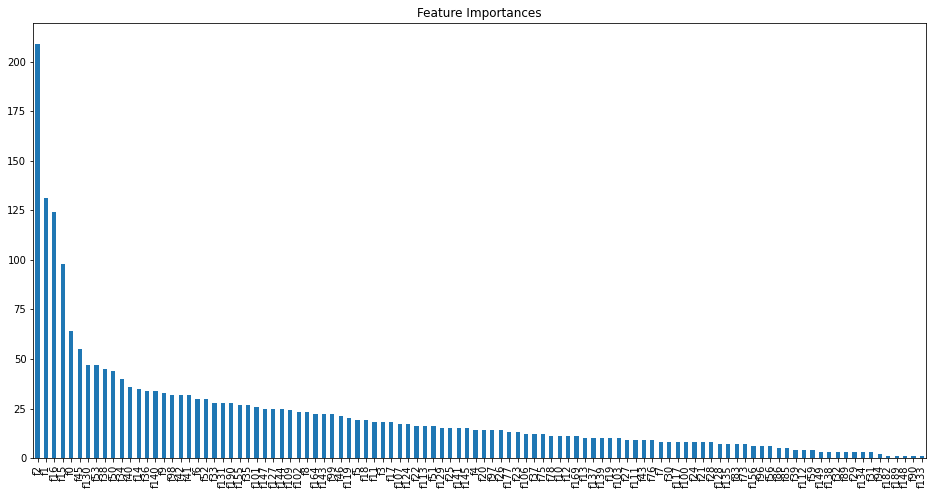

In [64]:
# Feature Importance
feature_importances = pd.Series(bst.get_fscore()).sort_values(ascending=False)
feature_importances.plot(kind='bar', title='Feature Importances', figsize=(16, 8))

In [100]:
# Save the model
pickle.dump(bst, open('Airbnb_NewUsersBookingPrediction.pkl', 'wb'))

## 5.0 Deploy the Model with 'test_users.csv' ##

In [94]:
# Load a NumPy array into DMatrix
df_test_xgb = xgb.DMatrix(Xtest)

# Make predictions for test dataset
df_test_prediction = bst.predict(df_test_xgb)
df_test_prediction

In [105]:
# Obtain the top 5 ranking destination countries
test_id = df_test['id']

ids = []  #list of ids
cts = []  #list of countries
for i in range(len(test_id)):
    idx = test_id[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(df_test_prediction[i])[::-1])[:5].tolist()

test_prediction_results = pd.DataFrame(np.column_stack((ids, cts)), columns=['id', 'country'])

# Groupby the dataframe
test_prediction_results1 = test_prediction_results.groupby(by = 'id').agg({'country':list})
print(test_prediction_results1)

                             country
id                                  
0010k6l0om  [NDF, US, GB, other, FR]
0031awlkjq  [US, NDF, other, GB, FR]
00378ocvlh  [US, NDF, other, FR, GB]
0048rkdgb1  [NDF, US, GB, other, FR]
0057snrdpu  [US, NDF, other, FR, DE]
...                              ...
zzu6ezwap2  [US, NDF, other, GB, FR]
zzunwylrfv  [NDF, US, GB, other, FR]
zzv6z6rjr9  [NDF, US, GB, other, FR]
zzx0hfd74v  [US, NDF, other, GB, DE]
zzxox7jnrx  [US, NDF, other, GB, DE]

[62096 rows x 1 columns]
